In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import distclassipy as dcpy

os.chdir("../")
from pathlib import Path
import matplotlib.gridspec as gridspec
import sys

sys.path.append("scripts")
import utils

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
seed_val = settings_dict["seed_choice"]
np.random.seed(seed_val)
sns_dict = settings_dict["sns_dict"]
sns.set_theme(**sns_dict)

In [3]:
# custom_hues = ["#3B4CC0", "#1FA187", "#FBAE17", "#D21F26"]
ibm_palette_hues = ["#648FFF", "#785EF0", "#DC267F", "#FE6100", "#FFB000"]
# https://davidmathlogic.com/colorblind/
sns.set_palette(ibm_palette_hues)

In [4]:
all_metrics = settings_dict["all_metrics"]

In [5]:
reduced_features = pd.read_parquet("data/reduced_features.parquet")
reduced_features["class"].value_counts()

class
EB      98473
RRL     45096
DSCT     8245
CEP      1662
Name: count, dtype: int64

In [7]:
n_cols = 5
n_objs = 1000

# 69% Features: ['Harmonics_phase_5_Y', 'Harmonics_mse_Y', 'Harmonics_mag_7_Y', 'Harmonics_phase_3_z', 'n_forced_phot_band_after_Y', 'Harmonics_phase_4_g', 'max_brightness_after_band_g', 'Harmonics_phase_2_z', 'Harmonics_phase_2_z', 'Harmonics_phase_3_z']
# 65% Features: ['Harmonics_phase_6_r', 'Power_rate_4', 'Harmonics_mag_5_Y', 'Harmonics_phase_3_g', 'r-i']
# 80% Features: ['Power_rate_4', 'Harmonics_mag_5_Y', 'Harmonics_phase_3_r', 'r-i']

col_select = list(np.random.choice(reduced_features.columns[:-1], n_cols))
print(f"Features: {col_select}")
temp = reduced_features.loc[:, col_select + ["class"]].dropna()
assert (temp["class"].value_counts() > n_objs).all()
temp["class"].value_counts()

Features: ['Harmonics_chi_Y', 'SPM_beta_Y', 'SPM_tau_rise_i', 'max_brightness_after_band_r', 'Harmonics_mag_1_i']


class
EB      95379
RRL     38195
DSCT     7397
CEP      1488
Name: count, dtype: int64

In [8]:
temp = temp.groupby("class").sample(n=n_objs, random_state=seed_val)
temp = temp.sample(frac=1, random_state=seed_val)

In [9]:
X = temp[col_select].to_numpy()
y = temp["class"].to_numpy()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=settings_dict["seed_choice"]
)

In [11]:
lcdc = dcpy.DistanceMetricClassifier(
    scale=True,
    central_stat="median",
    dispersion_stat="std",
)

In [12]:
lcdc.fit(X_train, y_train)

DistanceMetricClassifier()

In [13]:
y_pred_test = lcdc.predict_and_analyse(X_test, metric="canberra")
y_testdf = pd.DataFrame(data=y_test, columns=["class"])
y_testdf["pred"] = y_pred_test

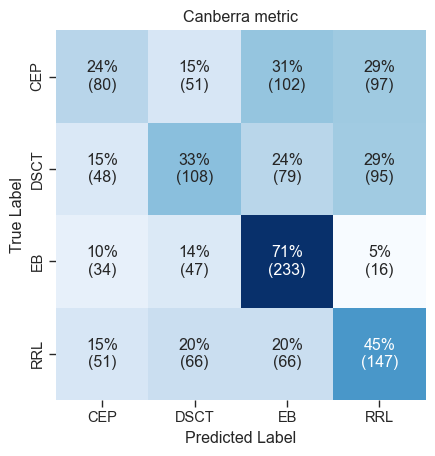

F1 = 41.45 %
Accuracy = 43.03 %
Matthew's Coefficient = 24.42 %


In [14]:
acc = accuracy_score(y_test, y_pred_test)
f1score = f1_score(y_test, y_pred_test, average="macro")
matthew_coef = matthews_corrcoef(y_test, y_pred_test)

ax = utils.plot_cm(y_true=y_test, y_pred=y_pred_test)
ax.set_title(f"Canberra metric")
plt.show()

print(
    f"F1 = {f1score*100:.2f} %\nAccuracy = {acc*100:.2f} %\nMatthew's Coefficient = {matthew_coef*100:.2f} %"
)